In [382]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [407]:
data = pd.read_csv('VIX_data.csv',index_col="Date")
data.index = pd.to_datetime(data.index)
data_clean = data
data_clean.fillna(data_clean.mean(), inplace=True)

In [408]:
# Create a new column for difference between high and low for each index
indexes = ['DJI', 'NASDAQ', 'GOLD', 'OIL', 'FTSE', 'NIKKEI', 'RUSSELL2000']
for index in indexes:
    data_clean[index+' High Minus Low'] = data_clean[index+' High'] - data_clean[index+' Low']
# Remove all open and close prices
data_clean = data_clean.drop(columns=['DJI Open', 'DJI Close', 'NASDAQ Open', 'NASDAQ Close', 'GOLD Open', 'GOLD Close', 'OIL Open', 'OIL Close', 'FTSE Open', 'FTSE Close', 'NIKKEI Open', 'NIKKEI Close', 'RUSSELL2000 Open', 'RUSSELL2000 Close'])
# Remove outliers in the data
# data_clean = data_clean[(np.abs(data_clean['VIX']-data_clean['VIX'].mean()) <= (3*data_clean['VIX'].std()))]

    


In [409]:
data_clean

,Unemployment Rate,CPI,Three Month T Bill Rate,Six Month T Bill Rate,10-Year Treasury Constant Maturity Rate,Fed Rate,BBB Rate,SP500 Index,VIX,GDP,...,OIL Low,OIL Adj Close,OIL Volume,DJI High Minus Low,NASDAQ High Minus Low,GOLD High Minus Low,OIL High Minus Low,FTSE High Minus Low,NIKKEI High Minus Low,RUSSELL2000 High Minus Low
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,5.7,237.430,0.02,0.05,2.30,0.09,3.50,1982.300,16.530,17912.079,...,79.440002,80.540001,7448385,1540.418945,524.909668,89.599976,13.519997,550.099609,2004.879883,133.859985
2014-11-01,5.8,236.983,0.02,0.07,2.33,0.09,3.63,2039.820,13.330,17912.079,...,65.690002,66.150002,6055929,616.470703,215.939941,69.400024,15.290001,328.200195,807.169922,39.780029
2014-12-01,5.6,236.252,0.03,0.11,2.21,0.12,3.78,2063.890,15.155,17912.079,...,52.439999,53.270000,6919717,1035.859375,267.640137,96.300049,17.100002,608.500000,1357.890625,86.929932
2015-01-01,5.7,234.747,0.03,0.08,1.88,0.11,3.64,2024.465,19.455,18063.529,...,43.580002,48.240002,7699363,815.478516,213.899902,134.000000,11.529999,566.799805,1258.019531,61.500000
2015-04-01,5.4,236.222,0.02,0.09,1.94,0.12,3.41,2097.290,13.300,18279.784,...,47.049999,59.630001,7959153,590.550781,275.439941,49.599976,12.799999,357.300293,1324.169922,62.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,3.9,313.207,5.24,5.15,4.54,5.33,5.84,5108.065,15.745,29016.714,...,80.879997,81.930000,6841962,2203.441406,1267.870117,199.000000,6.790001,406.100098,3964.160156,194.520020
2024-05-01,4.0,313.225,5.25,5.17,4.48,5.33,5.75,5256.815,12.920,29016.714,...,76.150002,76.989998,6613971,2296.859375,1475.020508,158.199951,5.419998,363.000488,1820.160156,144.290039
2024-06-01,4.1,313.049,5.24,5.15,4.31,5.33,5.63,5433.740,12.645,29016.714,...,72.480003,81.540001,5649911,1324.011719,1388.570312,99.700195,10.239998,258.800293,1838.429688,95.300049


In [410]:
explanatory_vars = data_clean.drop(columns=['VIX'])
y_entire = data_clean['VIX']

# Unlagged

In [387]:
# Split the data into training and testing sets first
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(explanatory_vars, y_entire, test_size=0.09, shuffle=False)

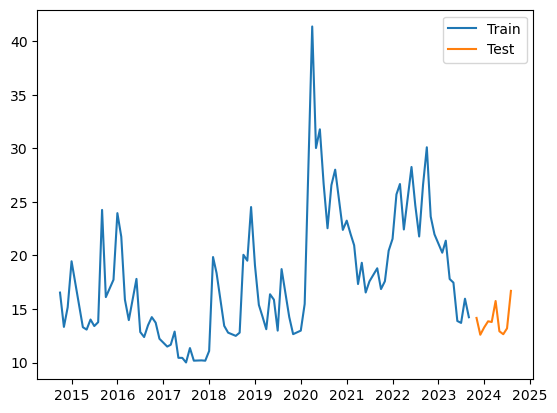

In [388]:
# Plot test and train data 
plt.plot(y_train_full, label='Train')
plt.plot(y_test_full, label='Test')
plt.legend()
plt.show()


In [389]:
all_feature_names = list(X_train_full.columns)
best_features = []
best_rmse = float('inf')
remaining_features = all_feature_names.copy()

In [390]:
for i in range(len(remaining_features)):
    feature_to_add = None
    for feature in remaining_features:
        selected_features = best_features + [feature]
        X_train_subset, X_opt_subset, y_train_subset, y_opt_subset = train_test_split(X_train_full[selected_features], y_train_full, test_size=0.1, shuffle=False)
        rf_model_subset = RandomForestRegressor(n_estimators=500, random_state=42)
        rf_model_subset.fit(X_train_subset, y_train_subset)
        y_pred_subset = rf_model_subset.predict(X_opt_subset)
        # Calculate rmse
        rmse_subset = root_mean_squared_error(y_opt_subset, y_pred_subset)
        print(selected_features)
        print(rmse_subset)
        if rmse_subset < best_rmse:
            best_rmse = rmse_subset
            feature_to_add = feature
    if feature_to_add:
        best_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
    else:
        break

best_features, best_rmse

['Unemployment Rate']
4.040070636573869
['CPI']
10.960637720776216
['Three Month T Bill Rate']
10.38692871568299
['Six Month T Bill Rate']
10.835583178163613
['10-Year Treasury Constant Maturity Rate']
9.743205826474648
['Fed Rate']
9.678494610023073
['BBB Rate']
10.253683350639303
['SP500 Index']
4.1929719004877475
['GDP']
10.627495199335524
['Initial Claims']
5.476856827727454
['JPY/USD Spot Rate']
9.020171889586146
['Total Nonfarm Employees']
10.865764670399514
['Spot Crude Oil Price']
5.474197675379537
['SP500 Volume']
3.49315690216889
['NASDAQ High']
6.555089594158868
['NASDAQ Low']
5.193962976834785
['NASDAQ Adj Close']
5.592160242960654
['NASDAQ Volume']
5.976663989363143
['DJI High']
4.853910922622092
['DJI Low']
5.048254108856857
['DJI Adj Close']
5.125810751790442
['DJI Volume']
5.435262777350316
['RUSSELL2000 High']
8.24017102468819
['RUSSELL2000 Low']
4.9406160296577175
['RUSSELL2000 Adj Close']
5.753094162564207
['RUSSELL2000 Volume']
3.478779443438482
['FTSE High']
5.9065

(['NIKKEI Low', 'SP500 Index', 'DJI High Minus Low', 'USD INDEX High'],
 2.4167871002448753)

In [400]:
X = X_train_full[selected_features]
y = y_train_full

In [401]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(n_estimators=500, random_state=42)

In [402]:
y_pred = rf_model.predict(X_test_full[selected_features])
rmse = root_mean_squared_error(y_test_full, y_pred)
rmse

4.195271833857737

In [403]:
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [404]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

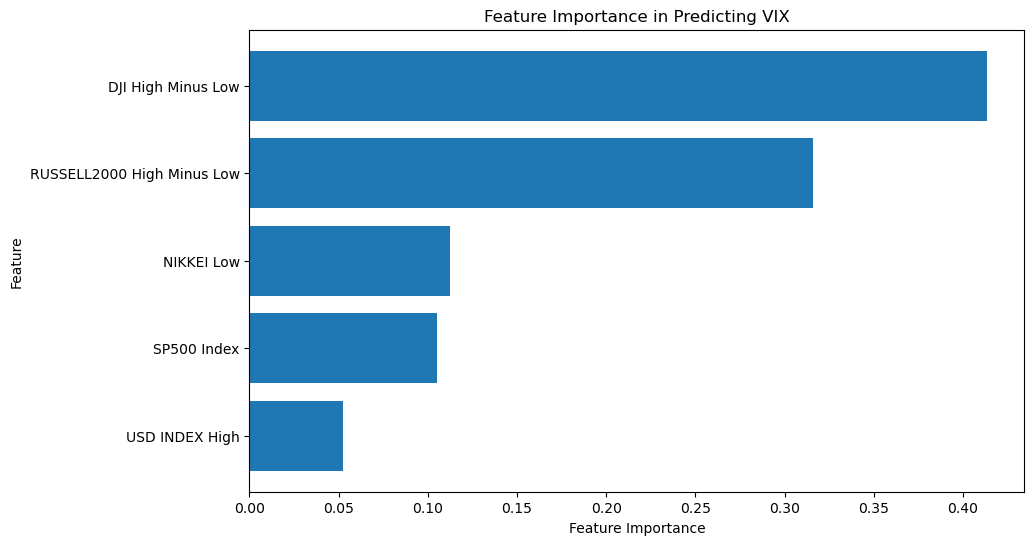

In [396]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting VIX')
plt.gca().invert_yaxis()
plt.show()

In [405]:
# Add dates back to predictions
y_pred_df = pd.DataFrame(y_pred, index=X_test_full.index, columns=['VIX Prediction'])
y_test_df = pd.DataFrame(y_test_full, index=X_test_full.index, columns=['VIX'])

In [406]:
y_pred_df

,VIX Prediction
Date,
2023-11-01,22.47082
2023-12-01,16.27965
2024-01-01,15.40444
2024-02-01,15.56904
2024-03-01,15.61431
2024-04-01,17.36001
2024-05-01,16.85182
2024-06-01,15.60624
2024-07-01,17.80172


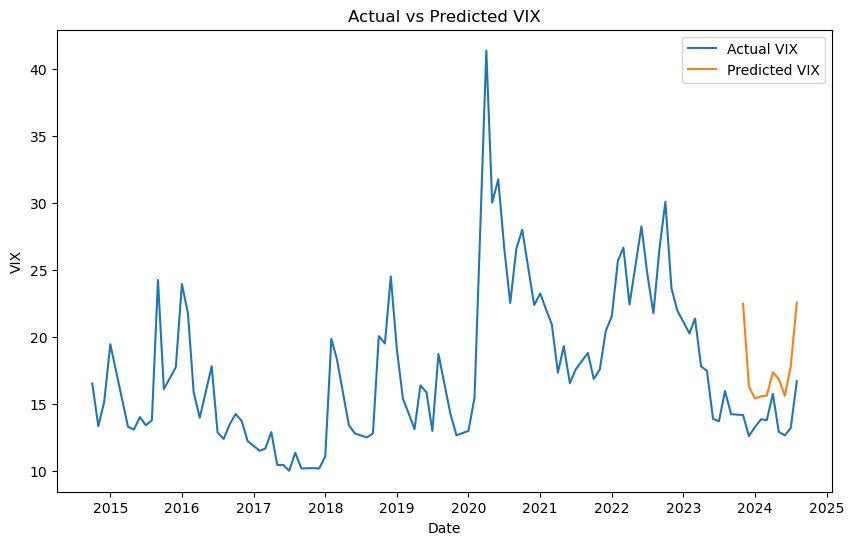

In [412]:
# Plot the actual VIX for the entire time series and the predicted VIX for the test set
plt.figure(figsize=(10, 6))
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.plot(y_entire, label='Actual VIX')
plt.plot(y_pred_df.index, y_pred_df['VIX Prediction'], label='Predicted VIX')
plt.legend()
plt.show()

